In [1]:
import torch
import torch.optim as optim

In [2]:
from bnet.train import Learner
from bnet.databunch import DataBunch
from bnet.activations import Swish, Mila, Mish, BentID
from bnet.models import mininest_ba, mininest_bn, mininet, xmininet, xsemininet

In [3]:
import torchvision.transforms as transforms

In [4]:
from bnet.optimizers import Ranger, Adahessian, Ralamb, RangerLars

In [5]:
import os
from pathlib import Path
import pandas as pd

In [6]:
def SEED_ALL(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [7]:
SEED_ALL(42)

In [8]:
tfms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomCrop(128, 4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [9]:
ROOT = Path('./data/imagenette2-160/')
data = DataBunch(root=ROOT, bs=32, num_workers=0, tfms=tfms)

Removing grayscale from: train dataset



Removing grayscale from: valid dataset


## 3. mininet - bn with AdaHessian

In [15]:
# hyper params
wd = 0.001
lr = 1e-2
betas = (0.9, 0.99)
eps = 1e-6
p = 0.2

# creating model
model = xsemininet(c_in=3, n_out=10, norm='bn', p=p, act_cls='mish')

# selecting optimizer
opt_fn = Adahessian(model.parameters(), lr=lr, weight_decay=wd, betas=betas, eps=eps)

# cross entropy for loss
loss_fn = torch.nn.CrossEntropyLoss()

# creating learner
learn = Learner(
    data=data,
    model=model,
    opt_fn=opt_fn,
    loss_fn=loss_fn,
    lr=lr,
    wd=wd
)

In [ ]:
learn.fit(5, ada=True)

C:\Users\dmber\Documents\research\bnet\bnet\optimizers\adahessian.py:151: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.759340, Train acc: 0.418460, Valid loss: 1.412886, Valid acc: 0.546162


## 2. mininet - bnet + mish + RangerLars + FlatAnneal
with data augmentation

In [33]:
# hyper params
wd = 0.001
lr = 1e-2
betas = (0.9, 0.99)
eps = 1e-6
p = 0.2

# creating model
model = xsemininet(c_in=3, n_out=10, norm='bnet', p=p, act_cls='mish')

# selecting optimizer
opt_fn = RangerLars(model.parameters(), lr=lr, weight_decay=wd, betas=betas, eps=eps)

# cross entropy for loss
loss_fn = torch.nn.CrossEntropyLoss()

# creating learner
learn = Learner(
    data=data,
    model=model,
    opt_fn=opt_fn,
    loss_fn=loss_fn,
    lr=lr,
    wd=wd
)

In [34]:
learn.fit_flat_anneal(5)

Train loss: 1.450431, Train acc: 0.522375, Valid loss: 1.435270, Valid acc: 0.554720
Train loss: 0.940998, Train acc: 0.693417, Valid loss: 0.749532, Valid acc: 0.756483
Train loss: 0.723431, Train acc: 0.761833, Valid loss: 0.724620, Valid acc: 0.766598
Train loss: 0.518572, Train acc: 0.830572, Valid loss: 0.584809, Valid acc: 0.817687
Train loss: 0.376308, Train acc: 0.872849, Valid loss: 0.520356, Valid acc: 0.836618


## 1. mininet - bnet + Mish + Ranger + One Cycle
no data augmentations

In [10]:
# hyper params
wd = 0.001
lr = 1e-2
betas = (0.9, 0.99)
eps = 1e-6
p = 0.3

# creating model
model = xsemininet(c_in=3, n_out=10, norm='bnet', p=p, act_cls='mish')

# selecting optimizer
opt_fn = Ranger(model.parameters(), lr=lr, weight_decay=wd, betas=betas, eps=eps)

# cross entropy for loss
loss_fn = torch.nn.CrossEntropyLoss()

# creating learner
learn = Learner(
    data=data,
    model=model,
    opt_fn=opt_fn,
    loss_fn=loss_fn,
    lr=lr,
    wd=wd
)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()



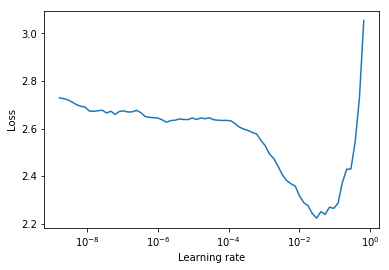

set state called


In [15]:
learn.lr_finder()

In [11]:
learn.fit_one_cycle(5)

Train loss: 1.382863, Train acc: 0.537543, Valid loss: 1.039317, Valid acc: 0.659492
Train loss: 0.914599, Train acc: 0.706756, Valid loss: 0.761907, Valid acc: 0.752075
Train loss: 0.794965, Train acc: 0.742793, Valid loss: 1.026675, Valid acc: 0.687500
Train loss: 0.671058, Train acc: 0.787758, Valid loss: 0.663165, Valid acc: 0.788122
Train loss: 0.355354, Train acc: 0.884574, Valid loss: 0.531803, Valid acc: 0.831432
